In [ ]:
# Binary Classifier implementation (model architecture, training, testing, etc.) derived from
#     https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
# loading subset of training data as per https://www.kaggle.com/sohier/competition-api-detailed-introduction/notebook
train_df = pd.read_csv('data/train.csv', low_memory=False, nrows=10**5, 
                       dtype={'row_id': 'int64', 'timestamp': 'int64', 'user_id': 'int32', 'content_id': 'int16', 'content_type_id': 'int8',
                              'task_container_id': 'int16', 'user_answer': 'int8', 'answered_correctly': 'int8', 'prior_question_elapsed_time': 'float32', 
                             'prior_question_had_explanation': 'boolean',
                             }
                      )

In [4]:
train_df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False
...,...,...,...,...,...,...,...,...,...,...
99995,99995,153647401,2078569,4334,0,275,3,0,6000.0,True
99996,99996,153692472,2078569,6436,0,276,3,0,9000.0,True
99997,99997,153722998,2078569,6446,0,277,2,1,21000.0,True
99998,99998,153759775,2078569,3715,0,278,3,0,12000.0,True


In [5]:
# get equal amount of correct and incorrect rows and shuffle data
num_correct_rows = train_df[train_df['answered_correctly'] == 1].shape[0]
num_incorrect_rows = train_df[train_df['answered_correctly'] == 0].shape[0]
num_train_rows = min(num_correct_rows, num_incorrect_rows) * 2

correct_df = train_df[train_df['answered_correctly'] == 1][:num_train_rows // 2]
incorrect_df = train_df[train_df['answered_correctly'] == 0][:num_train_rows // 2]
train_df = pd.concat([correct_df, incorrect_df]).dropna().sample(frac=1)

In [6]:
train_df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
29696,29696,538720756,650467,1408,0,115,2,1,22000.0,True
33484,33484,155753708,839139,9546,0,38,3,1,17000.0,True
38712,38712,8518395129,1084314,5255,0,493,0,1,50000.0,True
78305,78305,118788659,1716032,3973,0,27,0,0,14000.0,True
41066,41066,502750494,1095916,4256,0,328,3,1,21000.0,True
...,...,...,...,...,...,...,...,...,...,...
78066,78066,4756162102,1707189,482,0,451,0,0,36000.0,True
35868,35868,3097281635,975595,9099,0,910,3,1,14000.0,True
47142,47142,166598053,1255931,2619,0,127,1,1,29333.0,True
29228,29228,1514760073,637773,4229,0,129,3,1,27000.0,True


In [7]:
X = train_df.iloc[:, np.r_[2:7, 8:10]]
y = train_df.iloc[:, 7]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [9]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [10]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()

        self.layer_1 = nn.Linear(7, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BinaryClassifier()
model.to(device)

BinaryClassifier(
  (layer_1): Linear(in_features=7, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [12]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
class TrainDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_data = TrainDataset(torch.FloatTensor(np.array(X_train.values, dtype=np.float64)), 
                          torch.FloatTensor(y_train.values))

In [14]:
class TestDataset(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestDataset(torch.FloatTensor(np.array(X_test.values, dtype=np.float64)))

In [15]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [16]:
# calculates accuracy given predictions and labels
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [17]:
model.train()
epoch_losses = []
for e in range(1, EPOCHS + 1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)

        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    epoch_losses.append(epoch_loss / len(train_loader)) 

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.53158 | Acc: 71.913
Epoch 002: | Loss: 0.52016 | Acc: 72.436
Epoch 003: | Loss: 0.51892 | Acc: 72.233
Epoch 004: | Loss: 0.51767 | Acc: 72.410
Epoch 005: | Loss: 0.51704 | Acc: 72.357
Epoch 006: | Loss: 0.51673 | Acc: 72.270
Epoch 007: | Loss: 0.51419 | Acc: 72.508
Epoch 008: | Loss: 0.51685 | Acc: 72.292
Epoch 009: | Loss: 0.51808 | Acc: 72.236
Epoch 010: | Loss: 0.51596 | Acc: 72.380
Epoch 011: | Loss: 0.51572 | Acc: 72.413
Epoch 012: | Loss: 0.51517 | Acc: 72.511
Epoch 013: | Loss: 0.51348 | Acc: 72.607
Epoch 014: | Loss: 0.51531 | Acc: 72.425
Epoch 015: | Loss: 0.51461 | Acc: 72.452
Epoch 016: | Loss: 0.51506 | Acc: 72.410
Epoch 017: | Loss: 0.51398 | Acc: 72.458
Epoch 018: | Loss: 0.51507 | Acc: 72.379
Epoch 019: | Loss: 0.51346 | Acc: 72.668
Epoch 020: | Loss: 0.51576 | Acc: 72.453
Epoch 021: | Loss: 0.51366 | Acc: 72.433
Epoch 022: | Loss: 0.51389 | Acc: 72.334
Epoch 023: | Loss: 0.51687 | Acc: 72.318
Epoch 024: | Loss: 0.51390 | Acc: 72.461
Epoch 025: | Los

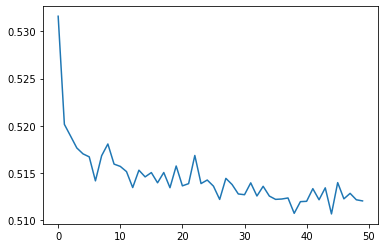

In [18]:
plt.plot(epoch_losses)

In [19]:
# get predictions for test data
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [20]:
# get performance on test data
print(confusion_matrix(y_test, y_pred_list))
print(classification_report(y_test, y_pred_list))

[[5108 4968]
 [ 207 9999]]
              precision    recall  f1-score   support

           0       0.96      0.51      0.66     10076
           1       0.67      0.98      0.79     10206

    accuracy                           0.74     20282
   macro avg       0.81      0.74      0.73     20282
weighted avg       0.81      0.74      0.73     20282

